In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from torch.nn.functional import normalize
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import optuna
import numpy as np
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.preprocessing import StandardScaler

In [2]:
class CNN1D(nn.Module):
    def __init__(self, input_size, output_size, conv_params, fc_params, batch_size):
        super(CNN1D, self).__init__()

        # 卷积层和池化层
        self.conv_layers = nn.ModuleList()
        input_channels = 1
        for params in conv_params:
            kernel_size = params['kernel_size']
            num_kernels = params['num_kernels']
            padding_size = (kernel_size - 1) // 2
            conv_block = nn.Sequential(
                nn.Conv1d(input_channels, num_kernels, kernel_size, padding=padding_size),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2, stride=2)
            )
            self.conv_layers.append(conv_block)
            input_channels = num_kernels

        # 计算全连接层的输入大小
        with torch.no_grad():
            sample_output = self._forward_conv(torch.randn(batch_size, 1, input_size))
            calculated_input_size = sample_output.view(sample_output.size(0), -1).size(1)

        # 全连接层
        self.fc_layers = nn.ModuleList()
        fc_input_size = calculated_input_size
        for params in fc_params:
            num_neurons = params['num_neurons']
            dropout = params['dropout']
            fc_block = nn.Sequential(
                nn.Linear(fc_input_size, num_neurons),
                nn.ReLU(),
                nn.Dropout(p=dropout)
            )
            self.fc_layers.append(fc_block)
            fc_input_size = num_neurons

        self.fc_final = nn.Linear(fc_input_size, output_size)
        

    def _forward_conv(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        for layer in self.fc_layers:
            x = layer(x)
        x = self.fc_final(x)
        return x


In [3]:
# 数据预处理
def prepare_data(file_path):
    df = pd.read_excel(file_path, header=0, engine='openpyxl')
    # 提取特征和标签列
    features = df.iloc[:, 1:].values
    labels = df.iloc[:, 0].values
    
    # 使用StandardScaler对特征进行标准化
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)  

    # 划分训练集和测试集
    X_train, X_val, y_train, y_val = train_test_split(
        features_scaled, labels, test_size=0.2, random_state=42) # stratify=labels, shuffle=True

    # 转换为PyTorch张量
    X_train_tensor = torch.FloatTensor(X_train).unsqueeze(1)  # 添加通道维度
    y_train_tensor = torch.FloatTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val).unsqueeze(1)
    y_val_tensor = torch.FloatTensor(y_val)

    # 将目标张量调整为二维形状
    y_train_tensor = y_train_tensor.view(-1, 1)
    y_val_tensor = y_val_tensor.view(-1, 1)

    return X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor



In [ ]:
def prepare_data(file_path):
    selected_columns = [
        3, 5, 6, 8, 12, 13, 16, 18, 20, 21, 22, 24, 26, 27, 28, 30, 31, 33, 35, 36, 38, 40, 41, 42, 44, 46, 47, 48, 50, 
        51, 52, 53, 55, 61, 62, 65, 67, 68, 69, 70, 80, 81, 85, 88, 90, 92, 93, 94, 95, 96, 98, 99, 101, 103, 104, 106, 
        111, 112, 115, 116, 121, 122, 123, 124, 125, 129, 130, 134, 138, 139, 142, 144, 145, 146, 147, 148, 150, 151, 
        152, 153, 154, 155, 156, 157, 158, 159, 162, 165, 166, 168, 169, 170, 171, 175, 176, 178, 179, 180, 194, 197, 
        201, 206, 208, 209, 210, 211, 214, 218, 223, 224, 226, 227, 228, 231, 233, 234, 235, 236, 237, 238, 239, 240, 
        241, 243, 246, 247, 248, 249, 252, 255, 256, 258, 259, 263, 264, 265, 268, 269, 270, 273, 275, 276, 277, 282, 
        283, 286, 287, 288, 289, 291, 295, 296, 298, 299, 301, 302, 304, 307, 308, 309, 311, 313, 316, 319, 321, 322, 
        323, 324, 329, 333, 334, 335, 339, 340, 342, 344, 350, 351, 353, 357, 358, 359, 360, 361, 362, 363, 365, 368, 
        369, 372, 373, 375, 383, 384, 386, 389, 393, 395, 396, 398, 402, 403, 404, 406, 410, 414, 415, 416, 420, 422, 
        423, 425, 426, 427, 428, 429, 433, 434, 435, 438, 439, 440, 442, 445, 446, 447, 450, 451, 453, 455, 456, 460, 
        462, 463, 467, 468, 472, 474, 475, 476, 477, 479, 480, 482, 486, 487, 489, 490, 491, 496, 498, 499, 501, 503, 
        504, 506, 508, 510, 511, 513, 516, 517, 518, 519, 520, 521, 523, 524, 525, 526, 528, 530, 531, 534, 535, 536, 
        538, 539, 541, 542, 543, 544, 545, 546, 550, 551, 552, 553, 554, 556, 558, 560, 563, 564, 565, 566, 568, 570, 
        571, 572, 573, 574, 576, 577, 580, 581, 584, 586, 587, 589, 591, 592, 598, 600, 601, 608, 612, 616, 617, 619, 
        621, 622, 628, 629, 630, 632, 633, 634, 635, 638, 643, 644, 647, 653, 656, 658, 659, 664, 665, 670, 671, 673, 
        675, 677, 681, 682, 683, 684, 686, 687, 688, 689, 690, 691, 694, 696, 698, 699, 703, 704, 705, 709, 711, 712, 
        713, 715, 717, 719, 720, 721, 727, 728, 730, 733, 736, 739, 741, 743, 747, 748, 749, 750, 751, 755, 756, 757, 
        758, 763, 764, 765, 774, 776, 777, 779, 783, 791, 792, 794, 795, 796, 797, 798, 800, 803, 805, 807, 808, 809, 
        819, 820, 822, 823, 825, 827, 830, 831, 835, 836, 838, 841, 842, 844, 847, 851, 852, 854, 855, 860, 861, 862, 
        863, 865, 866, 867, 868, 869, 870, 874, 875, 876, 877, 879, 880, 881, 883, 884, 885, 887, 888, 890, 894, 895, 
        896, 897, 899, 900, 901, 902, 905, 910, 914, 916, 917, 919, 920, 922, 923, 930, 931, 932, 936, 940, 941, 942, 
        946, 947, 950, 951, 953, 954, 955, 956, 960, 964, 965, 968, 974, 976, 979, 983, 986, 990, 992, 993, 996, 997, 
        998, 999, 1000, 1001, 1002, 1003, 1005, 1009, 1010, 1012, 1013, 1015, 1023, 1024, 1025, 1026, 1028, 1029, 1034, 
        1035, 1038, 1039, 1040, 1042, 1043, 1044, 1047, 1050, 1051, 1052, 1055, 1056, 1058, 1059, 1062, 1063, 1065, 1066, 
        1067, 1069, 1070, 1071, 1072, 1074, 1075, 1077, 1083, 1086, 1089, 1092, 1094, 1097, 1099, 1101, 1102, 1103, 1104, 
        1106, 1107, 1109, 1110, 1111, 1114, 1116, 1117, 1119, 1120, 1123, 1125, 1126, 1127, 1129, 1131, 1132, 1134, 1135, 
        1136, 1137, 1141, 1142, 1143, 1146, 1147, 1148, 1151, 1152, 1153, 1154, 1159, 1160, 1161, 1162, 1163, 1164, 1166, 
        1169, 1170, 1172, 1173, 1175, 1176, 1177, 1178, 1179, 1185, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1196, 1197, 
        1198, 1200, 1203, 1204, 1205, 1206, 1209, 1210, 1211, 1213, 1216, 1219, 1223, 1226, 1229, 1232, 1235, 1236, 1239, 
        1241, 1242, 1243, 1244, 1245, 1250, 1251, 1253, 1255, 1258, 1260, 1261, 1267, 1268, 1272, 1273, 1274, 1276, 1279, 
        1281, 1284, 1286, 1287, 1288, 1291, 1293, 1295, 1296, 1297, 1298, 1299, 1300, 1303, 1306, 1310, 1312, 1315, 1317, 
        1318, 1320, 1322, 1323, 1329, 1331, 1332, 1334, 1335, 1336, 1339, 1340, 1341, 1342, 1347, 1349, 1350, 1351, 1352, 
        1355, 1357, 1358, 1360, 1363, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1379, 1383, 1388, 1389, 1391, 1392, 
        1394, 1395, 1396, 1398, 1399, 1401, 1402, 1406, 1407, 1410, 1411, 1413, 1414, 1415, 1416, 1417, 1419, 1420, 1421, 
        1423, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1434, 1435, 1436, 1437, 1441, 1444, 1445, 1446, 1449, 1450, 1453, 
        1457, 1459, 1464, 1465, 1467, 1469, 1470, 1472, 1474, 1476, 1479, 1481, 1482, 1484, 1486, 1489, 1490, 1492, 1493, 
        1498, 1502, 1503, 1504, 1509, 1510, 1511, 1514, 1517, 1518, 1519, 1520, 1524, 1525, 1528, 1529, 1530, 1531, 1532, 
        1533, 1537, 1538, 1540, 1541, 1543, 1544, 1546, 1552, 1555, 1559, 1561, 1565, 1569, 1572, 1576, 1578, 1579, 1581, 
        1583, 1585, 1587, 1589, 1590, 1591, 1593, 1594, 1595, 1607, 1608, 1610, 1612, 1615, 1620, 1621, 1623, 1626, 1628, 
        1630, 1631, 1632, 1633, 1635, 1636, 1639, 1644, 1645, 1647, 1648, 1652, 1655, 1656, 1658, 1661, 1662, 1663, 1666, 
        1668, 1671, 1675, 1676, 1677, 1678, 1679, 1680, 1683, 1685, 1686, 1689, 1692, 1696, 1698, 1699, 1700, 1704, 1705, 
        1707, 1708, 1709, 1710, 1712, 1715, 1719, 1723, 1725, 1726, 1727, 1728, 1731, 1734, 1735, 1736, 1737, 1740, 1741, 
        1743, 1745, 1747, 1748, 1750, 1751, 1752, 1754, 1755, 1756, 1758, 1762, 1766, 1767, 1770, 1771, 1772, 1775, 1776, 
        1778, 1779, 1783, 1784, 1787, 1788, 1789, 1790, 1792, 1799, 1803, 1806, 1807, 1812, 1814, 1821, 1826, 1827, 1828, 
        1830, 1834, 1837, 1839, 1841, 1844, 1845, 1846, 1851, 1853, 1855, 1856, 1859, 1860, 1861, 1862, 1863, 1865, 1870, 
        1875, 1876, 1878, 1880, 1881, 1882, 1889, 1891, 1892, 1893, 1894, 1895, 1896, 1898, 1903, 1905, 1906, 1909, 1911, 
        1912, 1913, 1917, 1918, 1919, 1921, 1923, 1929, 1932, 1935, 1937, 1939, 1941, 1943, 1953, 1954, 1956, 1957, 1960, 
        1961, 1962, 1963, 1965, 1966, 1967, 1969, 1970, 1971, 1974, 1976, 1977, 1978, 1979, 1981, 1982, 1984, 1987, 1989, 
        1991, 1993, 1994, 1996, 1997, 1998, 1999, 2002, 2003, 2004, 2007, 2010, 2012, 2013, 2014, 2017, 2019, 2022, 2025, 
        2026, 2027, 2029, 2032, 2033, 2034, 2041, 2043, 2045, 2047, 2048, 2050, 2052, 2054, 2055, 2056, 2059, 2060, 2061, 
        2062, 2068, 2070, 2072, 2074, 2075, 2077, 2080, 2081, 2082, 2083, 2084, 2086, 2090, 2091, 2093, 2095, 2097, 2099, 
        2100, 2101, 2103, 2106, 2107, 2109, 2111, 2112, 2113, 2115, 2116, 2117, 2118, 2122, 2127, 2128, 2131, 2133, 2134, 
        2136, 2140, 2142, 2145, 2146, 2149, 2150
    ]
    
    df = pd.read_excel(file_path, header=0, engine='openpyxl')
    
    # 提取特征和标签列
    features = df.iloc[:, selected_columns].values
    labels = df.iloc[:, 0].values
    
    # 使用StandardScaler对特征进行标准化
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # 划分训练集和测试集
    X_train, X_val, y_train, y_val = train_test_split(
        features_scaled, labels, test_size=0.2, random_state=42, stratify=None
    )
    
    # 转换为PyTorch张量
    X_train_tensor = torch.FloatTensor(X_train).unsqueeze(1)  # 添加通道维度
    y_train_tensor = torch.FloatTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val).unsqueeze(1)
    y_val_tensor = torch.FloatTensor(y_val)
    
    # 将目标张量调整为二维形状
    y_train_tensor = y_train_tensor.view(-1, 1)
    y_val_tensor = y_val_tensor.view(-1, 1)
    
    return X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor


In [ ]:
def train_model(model, X_train, y_train, X_val, y_val, num_epochs, batch_size, lr, patience, save_path):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # 添加余弦退火学习率调度器
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

    
    # 添加学习率调度器
    #scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience, verbose=True)

    # 数据加载器
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    train_losses = []
    val_losses = []
    val_r2_scores = []
    val_predictions = []  # 验证集预测结果列表
    learning_rates = []   # 用于记录每个 epoch 后的学习率

    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            # 记录训练损失
            train_losses.append(loss.item())
        
        # 记录当前学习率
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        
        # 在每个 epoch 结束后计算并打印验证集上的损失
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            val_predictions = []  # 清空验证集预测结果列表
            for batch_X_val, batch_y_val in val_loader:
                batch_X_val, batch_y_val = batch_X_val.cuda(), batch_y_val.cuda()
                val_outputs = model(batch_X_val)
                val_loss += criterion(val_outputs, batch_y_val)
                val_predictions.append(val_outputs.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_predictions = np.concatenate(val_predictions)
        val_r2 = r2_score(y_val.cpu().numpy(), val_predictions)
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Validation Loss: {avg_val_loss.item()}, R^2 (Validation): {val_r2}")

        # 使用余弦退火学习率调度器更新学习率
        scheduler.step()        


        # 提前停止的逻辑
        if epoch > patience and avg_val_loss > min(val_losses[-patience:]):
            print("Early stopping")
            break

        val_losses.append(avg_val_loss)
        val_r2_scores.append(val_r2)

    # 保存训练好的模型权重
    torch.save(model.state_dict(), save_path)

    return avg_val_loss.item()


In [ ]:
def objective(trial):
    seed = 42
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    # 控制卷积块和全连接块的数量
    num_conv_blocks = trial.suggest_int('num_conv_blocks', 1, 3)
    num_fc_blocks = trial.suggest_int('num_fc_blocks', 1, 3)
    
    # 构建卷积块和全连接块的参数
    powers_of_two = [2**i for i in range(1, 5)]  # 1, 2, 4, 8, 16, 32
    conv_params = []
    for i in range(num_conv_blocks):
        kernel_size = trial.suggest_categorical(f'kernel_size_conv{i+1}', [3, 5, 9, 11, 13])
        num_kernels = trial.suggest_categorical(f'num_kernels_conv{i+1}', powers_of_two)
        conv_params.append({'kernel_size': kernel_size, 'num_kernels': num_kernels})
    
    fc_params = []
    for i in range(num_fc_blocks):
        #dropout = trial.suggest_float(f'dropout_fc{i+1}', 0.5, 0.7)
        dropout = 0.8
        num_neurons = trial.suggest_int(f'num_neurons_fc{i+1}', 50, 150) #500-1500
        fc_params.append({'num_neurons': num_neurons, 'dropout': dropout})
    
    #batch_size = trial.suggest_int('batch_size', 50, 500)
    # 生成2的整数次幂列表
    batch_size_powers = [2**i for i in range(6, 9)]  # 4, 8, 16, 32, 64, 128， 256， 512， 1024
    
    # 在列表中选择一个值作为 batch_size
    batch_size = trial.suggest_categorical('batch_size', batch_size_powers)
    num_epochs = trial.suggest_int('num_epochs', 1000, 3000)
    lr = trial.suggest_float('lr', 0.0001, 0.001)
    #lr = 0.01
    
    # 数据准备
    X_train, y_train, X_val, y_val = prepare_data('C:\\Users\\HongYI\\Desktop\\train.xlsx')

    # 创建模型
    input_size = X_train.size(2)
    output_size = 1

    model = CNN1D(input_size=input_size, output_size=output_size,
                  conv_params=conv_params, fc_params=fc_params, batch_size=batch_size)
    model = model.cuda()
    
    save_path = 'model_weights.pth'
    save_path_test = 'model_weights_test.pth'
    
    # 训练模型
    X_val, y_val = X_val.cuda(), y_val.cuda()
    
    train_model(model, 
                X_train, y_train, 
                X_val, y_val, 
                num_epochs=num_epochs, 
                lr=lr, 
                batch_size=batch_size, 
                patience=1000,
                save_path=save_path)

    model.eval()
    with torch.no_grad():
        predictions = model(X_val)

    predictions_cpu = predictions.cpu().numpy()
    y_val_cpu = y_val.cpu().numpy()   
     
    # 计算 R-squared
    r2 = r2_score(y_val_cpu, predictions_cpu.squeeze())
    r2 = max(0, min(1, r2))

    # 在每次评估后保存最佳模型权重
    if trial.should_prune():
        # 如果使用 Optuna 的剪枝功能，在不满足条件时剪枝，不需要保存模型
        return r2
    
    if study.best_r2 is None or r2 > study.best_r2:
        study.best_r2 = r2
        # 保存最佳权重
        torch.save(model.state_dict(), save_path_test)

    # 返回需要最大化的目标值
    return r2

[I 2024-09-01 22:39:22,729] A new study created in memory with name: no-name-c5a8ae2d-ad91-4793-bdc6-c05678cfeafc


Epoch 100/1051, Train Loss: 6.7104, Validation Loss: 1.2728, R^2 (Validation): 0.3931
Epoch 200/1051, Train Loss: 4.8606, Validation Loss: 0.5546, R^2 (Validation): 0.7473
Epoch 300/1051, Train Loss: 3.1423, Validation Loss: 0.4469, R^2 (Validation): 0.7914
Epoch 400/1051, Train Loss: 2.9429, Validation Loss: 0.3419, R^2 (Validation): 0.8404
Epoch 500/1051, Train Loss: 2.4740, Validation Loss: 0.3066, R^2 (Validation): 0.8581
Epoch 600/1051, Train Loss: 2.1638, Validation Loss: 0.3010, R^2 (Validation): 0.8590
Epoch 700/1051, Train Loss: 1.8578, Validation Loss: 0.2476, R^2 (Validation): 0.8838
Epoch 800/1051, Train Loss: 1.4127, Validation Loss: 0.2226, R^2 (Validation): 0.8943
Epoch 900/1051, Train Loss: 1.6615, Validation Loss: 0.2494, R^2 (Validation): 0.8823
Epoch 1000/1051, Train Loss: 1.4350, Validation Loss: 0.2384, R^2 (Validation): 0.8878
Early stopping


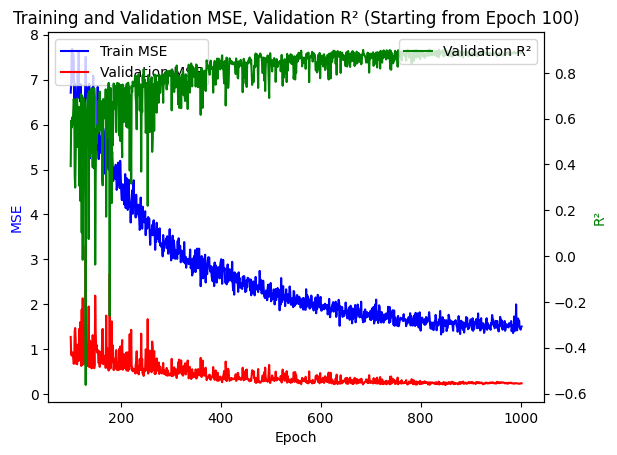

[I 2024-09-01 22:41:53,714] Trial 0 finished with value: 0.23954591155052185 and parameters: {'num_conv_blocks': 3, 'num_fc_blocks': 2, 'kernel_size_conv1': 13, 'num_kernels_conv1': 4, 'kernel_size_conv2': 13, 'num_kernels_conv2': 2, 'kernel_size_conv3': 9, 'num_kernels_conv3': 16, 'num_neurons_fc1': 90, 'num_neurons_fc2': 44, 'batch_size': 32, 'num_epochs': 1051, 'lr': 0.0024183472371198415}. Best is trial 0 with value: 0.23954591155052185.


Epoch 100/1443, Train Loss: 2.1696, Validation Loss: 2.4390, R^2 (Validation): -0.1490
Epoch 200/1443, Train Loss: 1.5011, Validation Loss: 0.5238, R^2 (Validation): 0.7514
Epoch 300/1443, Train Loss: 1.0803, Validation Loss: 0.2728, R^2 (Validation): 0.8713
Epoch 400/1443, Train Loss: 0.9275, Validation Loss: 0.3188, R^2 (Validation): 0.8592
Epoch 500/1443, Train Loss: 1.0250, Validation Loss: 0.2971, R^2 (Validation): 0.8639
Epoch 600/1443, Train Loss: 0.8239, Validation Loss: 0.2523, R^2 (Validation): 0.8848
Epoch 700/1443, Train Loss: 0.8019, Validation Loss: 0.2848, R^2 (Validation): 0.8719
Epoch 800/1443, Train Loss: 0.7018, Validation Loss: 0.1791, R^2 (Validation): 0.9206
Epoch 900/1443, Train Loss: 0.7617, Validation Loss: 0.1700, R^2 (Validation): 0.9258
Epoch 1000/1443, Train Loss: 0.6278, Validation Loss: 0.1509, R^2 (Validation): 0.9311
Early stopping


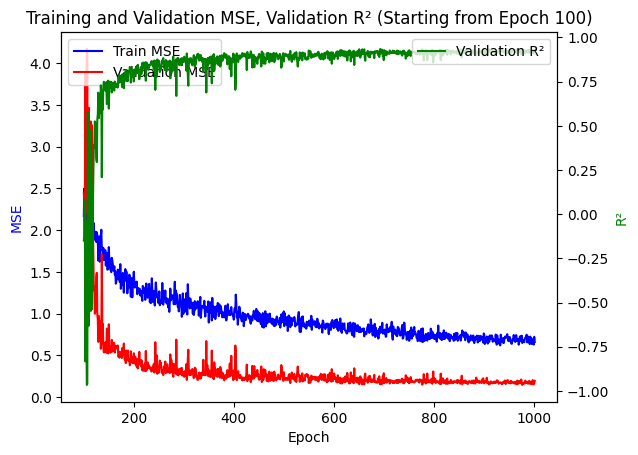

[I 2024-09-01 22:48:16,509] Trial 1 finished with value: 0.18804357945919037 and parameters: {'num_conv_blocks': 1, 'num_fc_blocks': 2, 'kernel_size_conv1': 13, 'num_kernels_conv1': 2, 'num_neurons_fc1': 54, 'num_neurons_fc2': 158, 'batch_size': 8, 'num_epochs': 1443, 'lr': 0.0007790200147489456}. Best is trial 1 with value: 0.18804357945919037.


Epoch 100/1276, Train Loss: 7.9435, Validation Loss: 2.4166, R^2 (Validation): -0.1387
Epoch 200/1276, Train Loss: 6.9863, Validation Loss: 1.6657, R^2 (Validation): 0.2151
Epoch 300/1276, Train Loss: 5.9829, Validation Loss: 0.9739, R^2 (Validation): 0.5411
Epoch 400/1276, Train Loss: 5.8714, Validation Loss: 0.8204, R^2 (Validation): 0.6134
Epoch 500/1276, Train Loss: 5.0275, Validation Loss: 0.8040, R^2 (Validation): 0.6212
Epoch 600/1276, Train Loss: 4.8925, Validation Loss: 0.8628, R^2 (Validation): 0.5935
Epoch 700/1276, Train Loss: 5.2739, Validation Loss: 0.9230, R^2 (Validation): 0.5651
Epoch 800/1276, Train Loss: 5.2653, Validation Loss: 0.7630, R^2 (Validation): 0.6405
Epoch 900/1276, Train Loss: 5.2637, Validation Loss: 0.8632, R^2 (Validation): 0.5933
Epoch 1000/1276, Train Loss: 5.0049, Validation Loss: 0.8256, R^2 (Validation): 0.6110
Early stopping


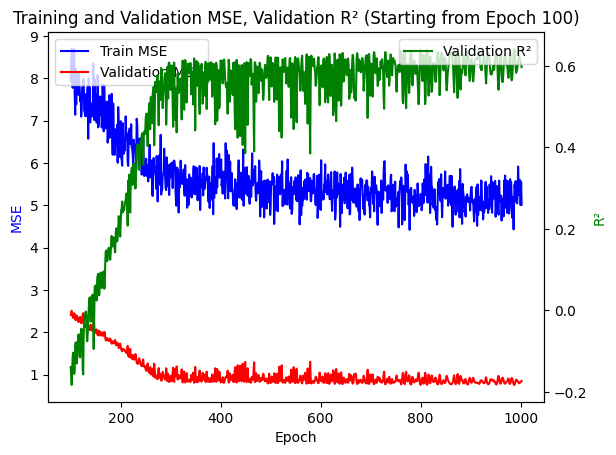

[I 2024-09-01 22:48:45,246] Trial 2 finished with value: 0.8552175760269165 and parameters: {'num_conv_blocks': 3, 'num_fc_blocks': 2, 'kernel_size_conv1': 3, 'num_kernels_conv1': 16, 'kernel_size_conv2': 9, 'num_kernels_conv2': 8, 'kernel_size_conv3': 9, 'num_kernels_conv3': 2, 'num_neurons_fc1': 82, 'num_neurons_fc2': 82, 'batch_size': 512, 'num_epochs': 1276, 'lr': 0.0010955486931445333}. Best is trial 1 with value: 0.18804357945919037.


Epoch 100/784, Train Loss: 3.9904, Validation Loss: 0.8180, R^2 (Validation): 0.6236
Epoch 200/784, Train Loss: 2.0739, Validation Loss: 1.0813, R^2 (Validation): 0.4754
Epoch 300/784, Train Loss: 1.1309, Validation Loss: 0.6911, R^2 (Validation): 0.6535
Epoch 400/784, Train Loss: 0.7118, Validation Loss: 0.6443, R^2 (Validation): 0.6750
Epoch 500/784, Train Loss: 0.4729, Validation Loss: 0.6115, R^2 (Validation): 0.6905
Epoch 600/784, Train Loss: 0.4352, Validation Loss: 0.5217, R^2 (Validation): 0.7349
Epoch 700/784, Train Loss: 0.3771, Validation Loss: 0.4907, R^2 (Validation): 0.7507


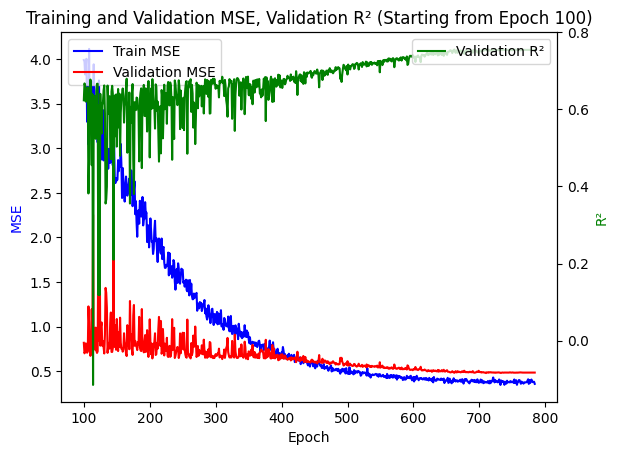

[I 2024-09-01 22:51:18,371] Trial 3 finished with value: 0.5215985178947449 and parameters: {'num_conv_blocks': 2, 'num_fc_blocks': 1, 'kernel_size_conv1': 3, 'num_kernels_conv1': 2, 'kernel_size_conv2': 13, 'num_kernels_conv2': 2, 'num_neurons_fc1': 50, 'batch_size': 16, 'num_epochs': 784, 'lr': 0.005804747146966174}. Best is trial 1 with value: 0.18804357945919037.


Epoch 100/1911, Train Loss: 2.2278, Validation Loss: 0.5959, R^2 (Validation): 0.7054
Epoch 200/1911, Train Loss: 1.5691, Validation Loss: 0.6434, R^2 (Validation): 0.7022
Epoch 300/1911, Train Loss: 1.3379, Validation Loss: 0.7139, R^2 (Validation): 0.6826
Epoch 400/1911, Train Loss: 1.0941, Validation Loss: 0.4603, R^2 (Validation): 0.7859
Epoch 500/1911, Train Loss: 0.8517, Validation Loss: 0.4775, R^2 (Validation): 0.7731
Epoch 600/1911, Train Loss: 0.8603, Validation Loss: 0.4359, R^2 (Validation): 0.8000
Epoch 700/1911, Train Loss: 0.5876, Validation Loss: 0.3327, R^2 (Validation): 0.8385
Epoch 800/1911, Train Loss: 0.5197, Validation Loss: 0.3333, R^2 (Validation): 0.8376
Epoch 900/1911, Train Loss: 0.5209, Validation Loss: 0.3266, R^2 (Validation): 0.8386
Epoch 1000/1911, Train Loss: 0.3643, Validation Loss: 0.2859, R^2 (Validation): 0.8581
Early stopping


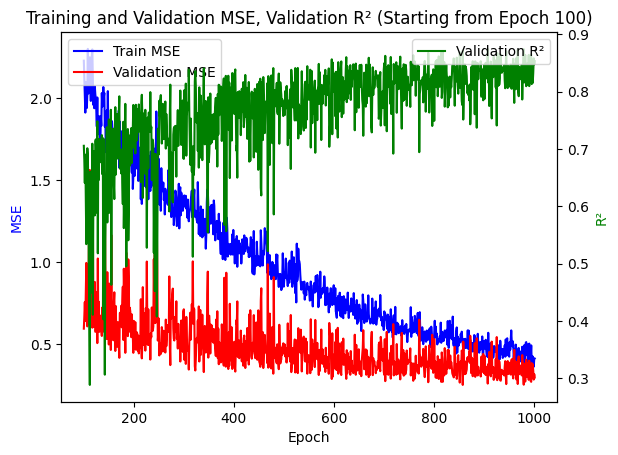

[I 2024-09-01 22:55:17,472] Trial 4 finished with value: 0.3116486072540283 and parameters: {'num_conv_blocks': 1, 'num_fc_blocks': 3, 'kernel_size_conv1': 11, 'num_kernels_conv1': 4, 'num_neurons_fc1': 11, 'num_neurons_fc2': 80, 'num_neurons_fc3': 118, 'batch_size': 16, 'num_epochs': 1911, 'lr': 0.0030233208931889025}. Best is trial 1 with value: 0.18804357945919037.


Epoch 100/1298, Train Loss: 7.0708, Validation Loss: 17.7303, R^2 (Validation): -7.3544
Epoch 200/1298, Train Loss: 3.9140, Validation Loss: 16.3475, R^2 (Validation): -6.7028
Epoch 300/1298, Train Loss: 3.8557, Validation Loss: 8.7782, R^2 (Validation): -3.1362
Epoch 400/1298, Train Loss: 3.0412, Validation Loss: 4.3970, R^2 (Validation): -1.0719
Epoch 500/1298, Train Loss: 2.4177, Validation Loss: 2.4928, R^2 (Validation): -0.1746
Epoch 600/1298, Train Loss: 2.1615, Validation Loss: 2.2429, R^2 (Validation): -0.0568
Epoch 700/1298, Train Loss: 1.7142, Validation Loss: 1.6008, R^2 (Validation): 0.2457
Epoch 800/1298, Train Loss: 1.7072, Validation Loss: 1.4218, R^2 (Validation): 0.3301
Epoch 900/1298, Train Loss: 1.7211, Validation Loss: 1.4623, R^2 (Validation): 0.3110
Epoch 1000/1298, Train Loss: 1.7866, Validation Loss: 1.4270, R^2 (Validation): 0.3276
Early stopping


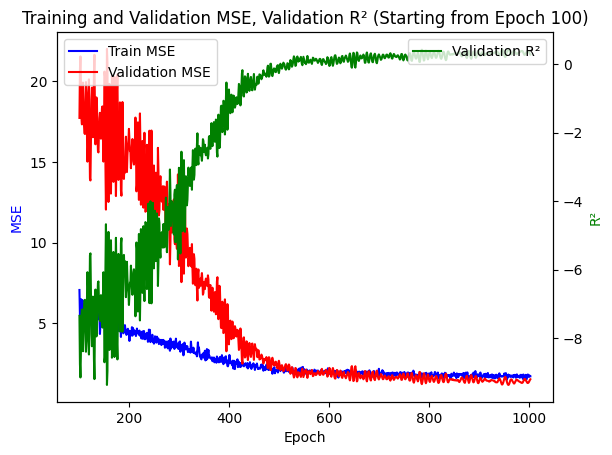

[I 2024-09-01 22:55:44,183] Trial 5 finished with value: 1.5386457443237305 and parameters: {'num_conv_blocks': 2, 'num_fc_blocks': 3, 'kernel_size_conv1': 5, 'num_kernels_conv1': 8, 'kernel_size_conv2': 3, 'num_kernels_conv2': 8, 'num_neurons_fc1': 86, 'num_neurons_fc2': 12, 'num_neurons_fc3': 136, 'batch_size': 1024, 'num_epochs': 1298, 'lr': 0.0077003416052291085}. Best is trial 1 with value: 0.18804357945919037.


Epoch 100/537, Train Loss: 1.3757, Validation Loss: 0.9251, R^2 (Validation): 0.5567
Epoch 200/537, Train Loss: 0.6095, Validation Loss: 0.5177, R^2 (Validation): 0.7481
Epoch 300/537, Train Loss: 0.5048, Validation Loss: 0.5025, R^2 (Validation): 0.7555
Epoch 400/537, Train Loss: 0.4187, Validation Loss: 0.4645, R^2 (Validation): 0.7742
Epoch 500/537, Train Loss: 0.4022, Validation Loss: 0.4612, R^2 (Validation): 0.7758


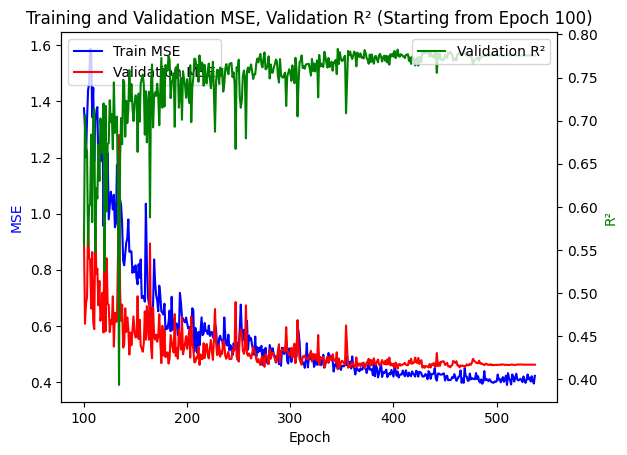

[I 2024-09-01 23:01:09,681] Trial 6 finished with value: 0.47600632905960083 and parameters: {'num_conv_blocks': 3, 'num_fc_blocks': 3, 'kernel_size_conv1': 9, 'num_kernels_conv1': 4, 'kernel_size_conv2': 11, 'num_kernels_conv2': 8, 'kernel_size_conv3': 11, 'num_kernels_conv3': 16, 'num_neurons_fc1': 93, 'num_neurons_fc2': 67, 'num_neurons_fc3': 61, 'batch_size': 8, 'num_epochs': 537, 'lr': 0.009382830075209049}. Best is trial 1 with value: 0.18804357945919037.


Epoch 100/693, Train Loss: 3.2350, Validation Loss: 18.8443, R^2 (Validation): -7.8793
Epoch 200/693, Train Loss: 2.2046, Validation Loss: 15.9162, R^2 (Validation): -6.4996
Epoch 300/693, Train Loss: 2.0746, Validation Loss: 16.6445, R^2 (Validation): -6.8427
Epoch 400/693, Train Loss: 1.9354, Validation Loss: 15.3716, R^2 (Validation): -6.2430
Epoch 500/693, Train Loss: 1.6819, Validation Loss: 15.6964, R^2 (Validation): -6.3960
Epoch 600/693, Train Loss: 1.5234, Validation Loss: 16.6519, R^2 (Validation): -6.8463


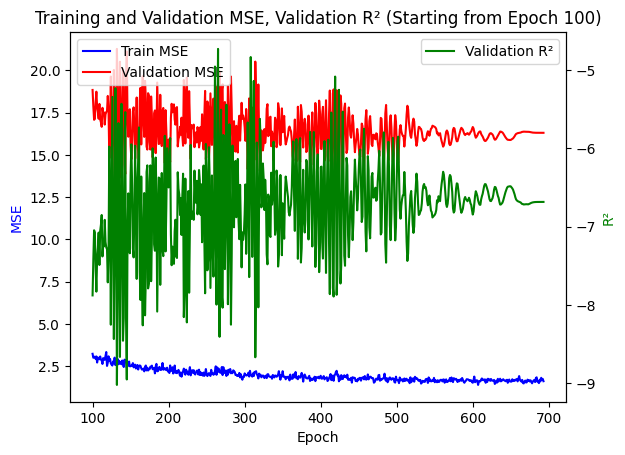

[I 2024-09-01 23:01:27,208] Trial 7 finished with value: 16.308963775634766 and parameters: {'num_conv_blocks': 1, 'num_fc_blocks': 2, 'kernel_size_conv1': 9, 'num_kernels_conv1': 16, 'num_neurons_fc1': 39, 'num_neurons_fc2': 195, 'batch_size': 1024, 'num_epochs': 693, 'lr': 0.009347476166749422}. Best is trial 1 with value: 0.18804357945919037.


Epoch 100/1249, Train Loss: 1.3832, Validation Loss: 0.6933, R^2 (Validation): 0.6688
Epoch 200/1249, Train Loss: 0.9398, Validation Loss: 0.7614, R^2 (Validation): 0.6513
Epoch 300/1249, Train Loss: 0.7592, Validation Loss: 0.6975, R^2 (Validation): 0.6626
Epoch 400/1249, Train Loss: 0.6104, Validation Loss: 0.6105, R^2 (Validation): 0.7028
Epoch 500/1249, Train Loss: 0.4637, Validation Loss: 0.6031, R^2 (Validation): 0.7126
Epoch 600/1249, Train Loss: 0.4249, Validation Loss: 0.5708, R^2 (Validation): 0.7229
Epoch 700/1249, Train Loss: 0.4076, Validation Loss: 0.6000, R^2 (Validation): 0.7082
Epoch 800/1249, Train Loss: 0.4108, Validation Loss: 0.5999, R^2 (Validation): 0.7084
Epoch 900/1249, Train Loss: 0.3627, Validation Loss: 0.6784, R^2 (Validation): 0.6727
Epoch 1000/1249, Train Loss: 0.3726, Validation Loss: 0.6179, R^2 (Validation): 0.7006
Early stopping


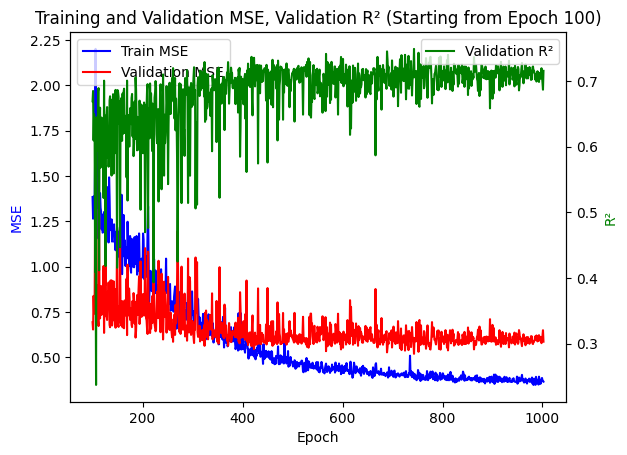

[I 2024-09-01 23:07:50,142] Trial 8 finished with value: 0.6045876741409302 and parameters: {'num_conv_blocks': 1, 'num_fc_blocks': 2, 'kernel_size_conv1': 9, 'num_kernels_conv1': 2, 'num_neurons_fc1': 32, 'num_neurons_fc2': 167, 'batch_size': 8, 'num_epochs': 1249, 'lr': 0.00824072706377779}. Best is trial 1 with value: 0.18804357945919037.


Epoch 100/1634, Train Loss: 6.5707, Validation Loss: 2.9749, R^2 (Validation): -0.4017
Epoch 200/1634, Train Loss: 4.8875, Validation Loss: 1.2840, R^2 (Validation): 0.3950
Epoch 300/1634, Train Loss: 4.2406, Validation Loss: 0.9616, R^2 (Validation): 0.5469
Epoch 400/1634, Train Loss: 4.2035, Validation Loss: 0.8219, R^2 (Validation): 0.6127
Epoch 500/1634, Train Loss: 3.8543, Validation Loss: 0.8169, R^2 (Validation): 0.6151
Epoch 600/1634, Train Loss: 4.0821, Validation Loss: 0.7540, R^2 (Validation): 0.6447
Epoch 700/1634, Train Loss: 3.6575, Validation Loss: 0.7629, R^2 (Validation): 0.6405
Epoch 800/1634, Train Loss: 3.9364, Validation Loss: 0.7169, R^2 (Validation): 0.6622
Epoch 900/1634, Train Loss: 3.6123, Validation Loss: 0.7073, R^2 (Validation): 0.6667
Epoch 1000/1634, Train Loss: 3.7061, Validation Loss: 0.6954, R^2 (Validation): 0.6723
Early stopping


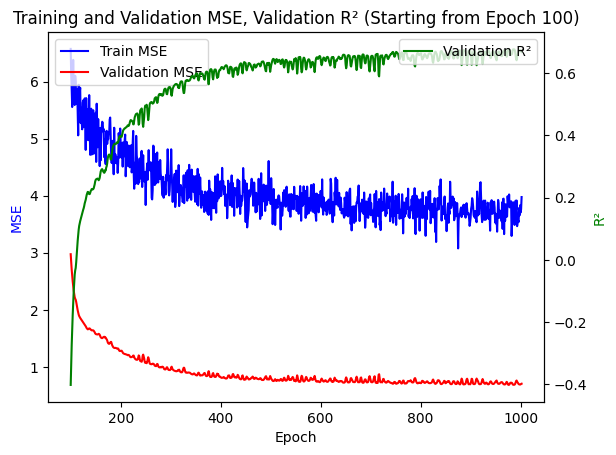

[I 2024-09-01 23:08:14,160] Trial 9 finished with value: 0.7065483927726746 and parameters: {'num_conv_blocks': 2, 'num_fc_blocks': 2, 'kernel_size_conv1': 3, 'num_kernels_conv1': 4, 'kernel_size_conv2': 3, 'num_kernels_conv2': 8, 'num_neurons_fc1': 156, 'num_neurons_fc2': 115, 'batch_size': 2048, 'num_epochs': 1634, 'lr': 0.0017178732220323489}. Best is trial 1 with value: 0.18804357945919037.


Epoch 100/1609, Train Loss: 2.5718, Validation Loss: 1.4675, R^2 (Validation): 0.3052
Epoch 200/1609, Train Loss: 2.4196, Validation Loss: 0.7536, R^2 (Validation): 0.6420
Epoch 300/1609, Train Loss: 1.7251, Validation Loss: 0.6438, R^2 (Validation): 0.6950
Epoch 400/1609, Train Loss: 2.0553, Validation Loss: 0.6991, R^2 (Validation): 0.6661
Epoch 500/1609, Train Loss: 1.8870, Validation Loss: 0.6976, R^2 (Validation): 0.6669
Epoch 600/1609, Train Loss: 2.0531, Validation Loss: 0.5810, R^2 (Validation): 0.7250
Epoch 700/1609, Train Loss: 1.6407, Validation Loss: 0.5185, R^2 (Validation): 0.7544
Epoch 800/1609, Train Loss: 1.7790, Validation Loss: 0.5108, R^2 (Validation): 0.7574
Epoch 900/1609, Train Loss: 1.7987, Validation Loss: 0.6195, R^2 (Validation): 0.7062
Epoch 1000/1609, Train Loss: 1.5696, Validation Loss: 0.4699, R^2 (Validation): 0.7776
Early stopping


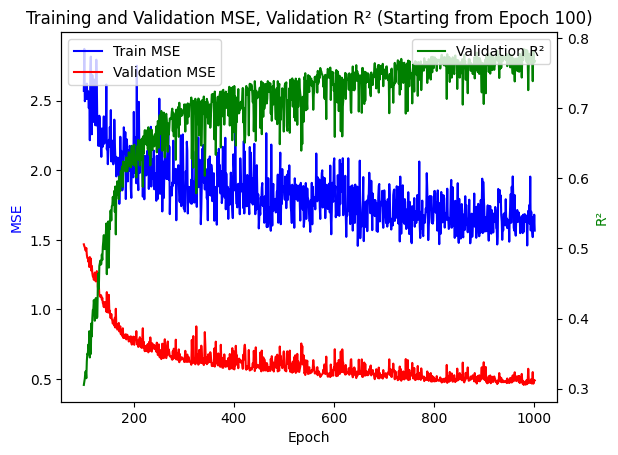

[I 2024-09-01 23:09:10,551] Trial 10 finished with value: 0.4933800995349884 and parameters: {'num_conv_blocks': 1, 'num_fc_blocks': 1, 'kernel_size_conv1': 13, 'num_kernels_conv1': 2, 'num_neurons_fc1': 164, 'batch_size': 64, 'num_epochs': 1609, 'lr': 0.0003907941006913237}. Best is trial 1 with value: 0.18804357945919037.


Epoch 100/1016, Train Loss: 2.7134, Validation Loss: 0.9921, R^2 (Validation): 0.5362
Epoch 200/1016, Train Loss: 2.2909, Validation Loss: 1.4827, R^2 (Validation): 0.2955
Epoch 300/1016, Train Loss: 1.9856, Validation Loss: 0.5856, R^2 (Validation): 0.7298
Epoch 400/1016, Train Loss: 1.8175, Validation Loss: 0.5590, R^2 (Validation): 0.7435
Epoch 500/1016, Train Loss: 1.6966, Validation Loss: 0.5340, R^2 (Validation): 0.7561
Epoch 600/1016, Train Loss: 1.5678, Validation Loss: 0.5526, R^2 (Validation): 0.7460
Epoch 700/1016, Train Loss: 1.4717, Validation Loss: 0.5453, R^2 (Validation): 0.7508
Epoch 800/1016, Train Loss: 1.4732, Validation Loss: 0.5535, R^2 (Validation): 0.7464
Epoch 900/1016, Train Loss: 1.3926, Validation Loss: 0.5581, R^2 (Validation): 0.7438
Epoch 1000/1016, Train Loss: 1.2807, Validation Loss: 0.5430, R^2 (Validation): 0.7513
Early stopping


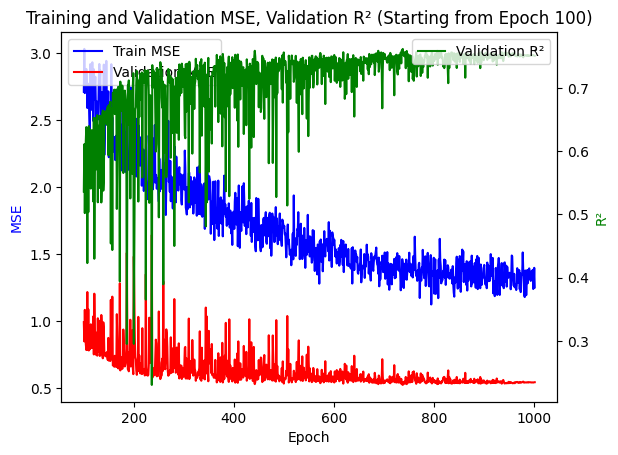

[I 2024-09-01 23:11:22,271] Trial 11 finished with value: 0.5290217995643616 and parameters: {'num_conv_blocks': 3, 'num_fc_blocks': 1, 'kernel_size_conv1': 13, 'num_kernels_conv1': 8, 'kernel_size_conv2': 13, 'num_kernels_conv2': 2, 'kernel_size_conv3': 9, 'num_kernels_conv3': 4, 'num_neurons_fc1': 123, 'batch_size': 32, 'num_epochs': 1016, 'lr': 0.003033386630865425}. Best is trial 1 with value: 0.18804357945919037.


Epoch 100/1024, Train Loss: 4.0084, Validation Loss: 1.1933, R^2 (Validation): 0.4394
Epoch 200/1024, Train Loss: 3.9712, Validation Loss: 0.6683, R^2 (Validation): 0.6918
Epoch 300/1024, Train Loss: 3.3743, Validation Loss: 0.6346, R^2 (Validation): 0.7072
Epoch 400/1024, Train Loss: 3.4466, Validation Loss: 0.6612, R^2 (Validation): 0.6920
Epoch 500/1024, Train Loss: 3.6545, Validation Loss: 0.8369, R^2 (Validation): 0.6069
Epoch 600/1024, Train Loss: 3.4366, Validation Loss: 0.6381, R^2 (Validation): 0.7028
Epoch 700/1024, Train Loss: 3.1536, Validation Loss: 0.5175, R^2 (Validation): 0.7616
Epoch 800/1024, Train Loss: 3.2568, Validation Loss: 0.5402, R^2 (Validation): 0.7503
Epoch 900/1024, Train Loss: 3.3901, Validation Loss: 0.5160, R^2 (Validation): 0.7621
Epoch 1000/1024, Train Loss: 2.9733, Validation Loss: 0.5254, R^2 (Validation): 0.7570
Early stopping


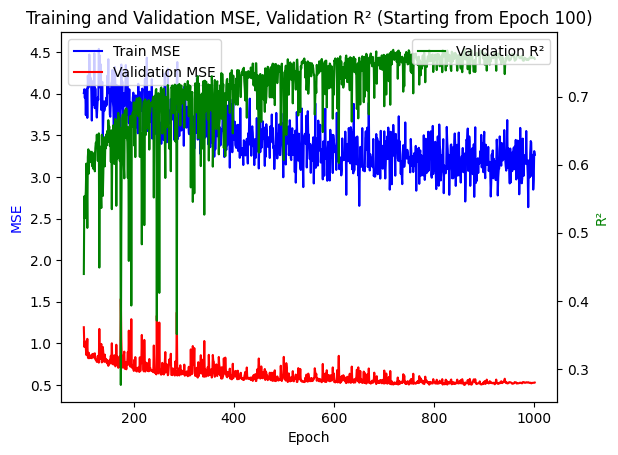

[I 2024-09-01 23:13:55,086] Trial 12 finished with value: 0.5186581611633301 and parameters: {'num_conv_blocks': 3, 'num_fc_blocks': 2, 'kernel_size_conv1': 13, 'num_kernels_conv1': 2, 'kernel_size_conv2': 5, 'num_kernels_conv2': 16, 'kernel_size_conv3': 3, 'num_kernels_conv3': 16, 'num_neurons_fc1': 127, 'num_neurons_fc2': 141, 'batch_size': 32, 'num_epochs': 1024, 'lr': 0.00019419580847380654}. Best is trial 1 with value: 0.18804357945919037.


Epoch 100/1562, Train Loss: 6.8791, Validation Loss: 1.0108, R^2 (Validation): 0.5358
Epoch 200/1562, Train Loss: 6.6762, Validation Loss: 0.7882, R^2 (Validation): 0.6346
Epoch 300/1562, Train Loss: 7.0162, Validation Loss: 0.8418, R^2 (Validation): 0.6070
Epoch 400/1562, Train Loss: 6.0028, Validation Loss: 0.7820, R^2 (Validation): 0.6057
Epoch 500/1562, Train Loss: 6.4712, Validation Loss: 0.5703, R^2 (Validation): 0.7143
Epoch 600/1562, Train Loss: 5.8701, Validation Loss: 0.5756, R^2 (Validation): 0.7160
Epoch 700/1562, Train Loss: 5.0580, Validation Loss: 0.4955, R^2 (Validation): 0.7551
Epoch 800/1562, Train Loss: 5.2397, Validation Loss: 0.7609, R^2 (Validation): 0.6214
Epoch 900/1562, Train Loss: 5.0674, Validation Loss: 0.6166, R^2 (Validation): 0.6956
Epoch 1000/1562, Train Loss: 4.9799, Validation Loss: 0.6076, R^2 (Validation): 0.7048
Early stopping


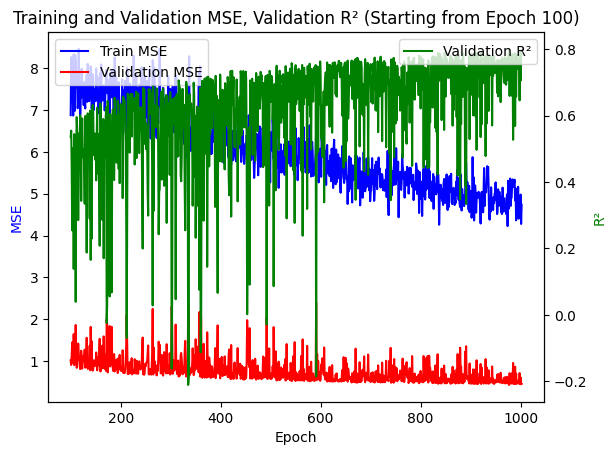

[I 2024-09-01 23:14:45,357] Trial 13 finished with value: 0.45728015899658203 and parameters: {'num_conv_blocks': 2, 'num_fc_blocks': 2, 'kernel_size_conv1': 13, 'num_kernels_conv1': 4, 'kernel_size_conv2': 13, 'num_kernels_conv2': 4, 'num_neurons_fc1': 199, 'num_neurons_fc2': 33, 'batch_size': 128, 'num_epochs': 1562, 'lr': 0.002376018037185806}. Best is trial 1 with value: 0.18804357945919037.


Epoch 100/1040, Train Loss: 5.5511, Validation Loss: 1.7382, R^2 (Validation): 0.1810
Epoch 200/1040, Train Loss: 5.1226, Validation Loss: 1.1119, R^2 (Validation): 0.4761
Epoch 300/1040, Train Loss: 4.8555, Validation Loss: 0.8232, R^2 (Validation): 0.6121
Epoch 400/1040, Train Loss: 4.6094, Validation Loss: 0.7864, R^2 (Validation): 0.6294
Epoch 500/1040, Train Loss: 4.6124, Validation Loss: 0.7747, R^2 (Validation): 0.6350
Epoch 600/1040, Train Loss: 4.6367, Validation Loss: 0.7080, R^2 (Validation): 0.6664
Epoch 700/1040, Train Loss: 4.4562, Validation Loss: 0.8187, R^2 (Validation): 0.6142
Epoch 800/1040, Train Loss: 4.1896, Validation Loss: 0.7291, R^2 (Validation): 0.6565
Epoch 900/1040, Train Loss: 4.4695, Validation Loss: 0.7703, R^2 (Validation): 0.6370
Epoch 1000/1040, Train Loss: 4.2175, Validation Loss: 0.7411, R^2 (Validation): 0.6508
Early stopping


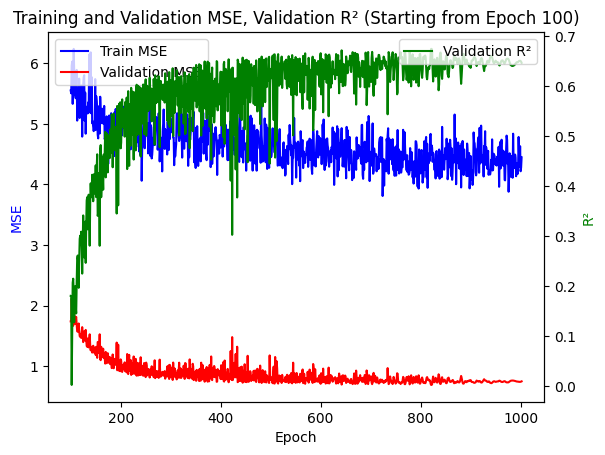

[I 2024-09-01 23:15:17,341] Trial 14 finished with value: 0.7488579750061035 and parameters: {'num_conv_blocks': 2, 'num_fc_blocks': 1, 'kernel_size_conv1': 13, 'num_kernels_conv1': 2, 'kernel_size_conv2': 11, 'num_kernels_conv2': 2, 'num_neurons_fc1': 66, 'batch_size': 256, 'num_epochs': 1040, 'lr': 0.00433151660065514}. Best is trial 1 with value: 0.18804357945919037.


Epoch 100/1424, Train Loss: 3.1384, Validation Loss: 0.7621, R^2 (Validation): 0.6494
Epoch 200/1424, Train Loss: 1.8422, Validation Loss: 0.5982, R^2 (Validation): 0.7263
Epoch 300/1424, Train Loss: 1.5526, Validation Loss: 0.5472, R^2 (Validation): 0.7494
Epoch 400/1424, Train Loss: 1.2749, Validation Loss: 0.5567, R^2 (Validation): 0.7479
Epoch 500/1424, Train Loss: 1.1228, Validation Loss: 0.4901, R^2 (Validation): 0.7812
Epoch 600/1424, Train Loss: 1.1317, Validation Loss: 0.4428, R^2 (Validation): 0.7966
Epoch 700/1424, Train Loss: 0.9550, Validation Loss: 0.1988, R^2 (Validation): 0.9085
Epoch 800/1424, Train Loss: 0.8899, Validation Loss: 0.1511, R^2 (Validation): 0.9334
Epoch 900/1424, Train Loss: 0.8174, Validation Loss: 0.1941, R^2 (Validation): 0.9143
Epoch 1000/1424, Train Loss: 0.8480, Validation Loss: 0.1481, R^2 (Validation): 0.9356
Early stopping


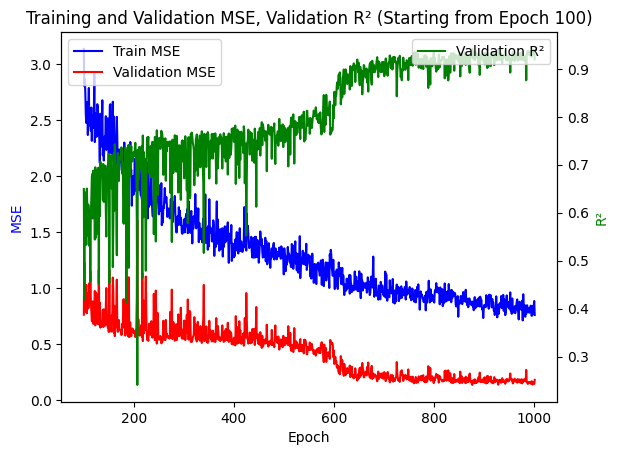

[I 2024-09-01 23:18:03,663] Trial 15 finished with value: 0.1699175089597702 and parameters: {'num_conv_blocks': 3, 'num_fc_blocks': 3, 'kernel_size_conv1': 5, 'num_kernels_conv1': 4, 'kernel_size_conv2': 5, 'num_kernels_conv2': 16, 'kernel_size_conv3': 13, 'num_kernels_conv3': 8, 'num_neurons_fc1': 113, 'num_neurons_fc2': 132, 'num_neurons_fc3': 197, 'batch_size': 32, 'num_epochs': 1424, 'lr': 0.0015712353501123374}. Best is trial 15 with value: 0.1699175089597702.


Epoch 100/1848, Train Loss: 1.8374, Validation Loss: 1.2301, R^2 (Validation): 0.4182
Epoch 200/1848, Train Loss: 1.0518, Validation Loss: 0.3401, R^2 (Validation): 0.8372
Epoch 300/1848, Train Loss: 0.8455, Validation Loss: 0.3183, R^2 (Validation): 0.8491
Epoch 400/1848, Train Loss: 0.7596, Validation Loss: 0.2025, R^2 (Validation): 0.9055
Epoch 500/1848, Train Loss: 0.6764, Validation Loss: 0.3618, R^2 (Validation): 0.8267
Epoch 600/1848, Train Loss: 0.6997, Validation Loss: 0.3142, R^2 (Validation): 0.8491
Epoch 700/1848, Train Loss: 0.6438, Validation Loss: 0.1868, R^2 (Validation): 0.9121
Epoch 800/1848, Train Loss: 0.5835, Validation Loss: 0.1890, R^2 (Validation): 0.9093
Epoch 900/1848, Train Loss: 0.5112, Validation Loss: 0.1263, R^2 (Validation): 0.9394
Epoch 1000/1848, Train Loss: 0.4260, Validation Loss: 0.1660, R^2 (Validation): 0.9212
Early stopping


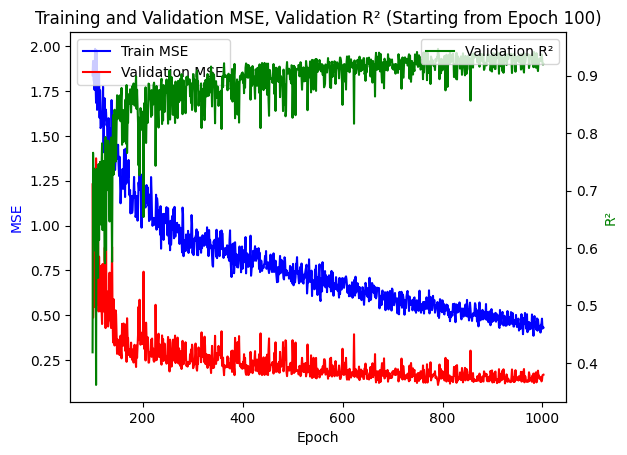

[I 2024-09-01 23:26:17,294] Trial 16 finished with value: 0.16895648837089539 and parameters: {'num_conv_blocks': 1, 'num_fc_blocks': 3, 'kernel_size_conv1': 5, 'num_kernels_conv1': 8, 'num_neurons_fc1': 125, 'num_neurons_fc2': 133, 'num_neurons_fc3': 195, 'batch_size': 8, 'num_epochs': 1848, 'lr': 0.001247079321913181}. Best is trial 16 with value: 0.16895648837089539.


Epoch 100/1957, Train Loss: 3.2282, Validation Loss: 0.6499, R^2 (Validation): 0.6943
Epoch 200/1957, Train Loss: 1.8026, Validation Loss: 0.5870, R^2 (Validation): 0.7243
Epoch 300/1957, Train Loss: 1.5102, Validation Loss: 0.5412, R^2 (Validation): 0.7450
Epoch 400/1957, Train Loss: 1.5653, Validation Loss: 0.5433, R^2 (Validation): 0.7460
Epoch 500/1957, Train Loss: 1.3072, Validation Loss: 0.4956, R^2 (Validation): 0.7687
Epoch 600/1957, Train Loss: 1.2063, Validation Loss: 0.6495, R^2 (Validation): 0.6930
Epoch 700/1957, Train Loss: 1.1275, Validation Loss: 0.4154, R^2 (Validation): 0.8055
Epoch 800/1957, Train Loss: 0.9060, Validation Loss: 0.3054, R^2 (Validation): 0.8574
Epoch 900/1957, Train Loss: 1.0181, Validation Loss: 0.1741, R^2 (Validation): 0.9180
Epoch 1000/1957, Train Loss: 0.8531, Validation Loss: 0.1501, R^2 (Validation): 0.9283
Early stopping


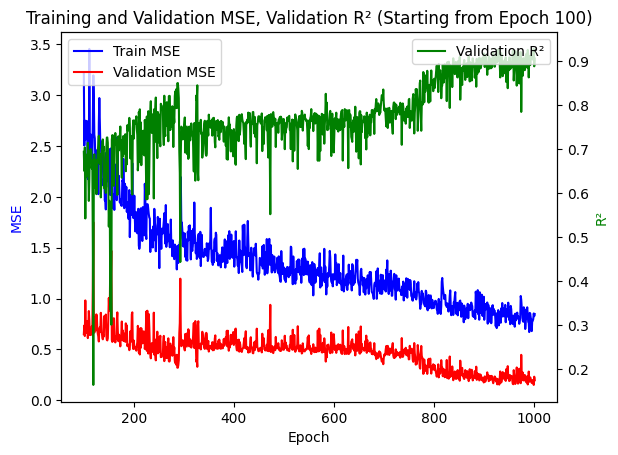

[I 2024-09-01 23:27:48,376] Trial 17 finished with value: 0.19826672971248627 and parameters: {'num_conv_blocks': 2, 'num_fc_blocks': 3, 'kernel_size_conv1': 5, 'num_kernels_conv1': 8, 'kernel_size_conv2': 5, 'num_kernels_conv2': 16, 'num_neurons_fc1': 120, 'num_neurons_fc2': 120, 'num_neurons_fc3': 199, 'batch_size': 64, 'num_epochs': 1957, 'lr': 0.003937268595810658}. Best is trial 16 with value: 0.16895648837089539.


Epoch 100/1804, Train Loss: 4.3040, Validation Loss: 0.7269, R^2 (Validation): 0.6751
Epoch 200/1804, Train Loss: 4.0450, Validation Loss: 1.1405, R^2 (Validation): 0.4287
Epoch 300/1804, Train Loss: 2.8347, Validation Loss: 0.9807, R^2 (Validation): 0.5303
Epoch 400/1804, Train Loss: 2.2363, Validation Loss: 0.4405, R^2 (Validation): 0.7977
Epoch 500/1804, Train Loss: 1.7970, Validation Loss: 0.3978, R^2 (Validation): 0.8132
Epoch 600/1804, Train Loss: 1.9077, Validation Loss: 0.3174, R^2 (Validation): 0.8549
Epoch 700/1804, Train Loss: 1.4596, Validation Loss: 0.2408, R^2 (Validation): 0.8896
Epoch 800/1804, Train Loss: 1.4603, Validation Loss: 0.2692, R^2 (Validation): 0.8727
Epoch 900/1804, Train Loss: 1.3766, Validation Loss: 0.2000, R^2 (Validation): 0.9044
Epoch 1000/1804, Train Loss: 1.3136, Validation Loss: 0.2230, R^2 (Validation): 0.8901
Early stopping


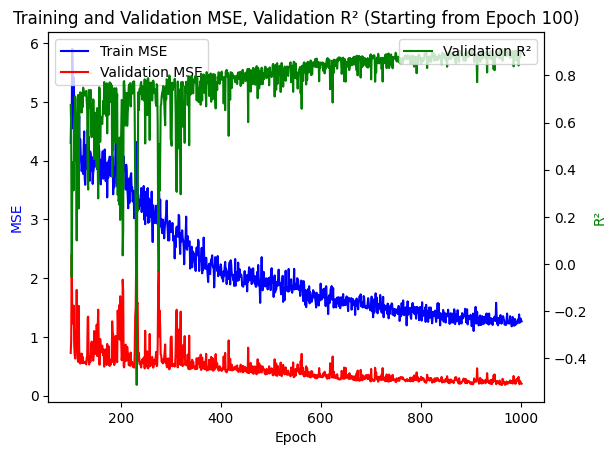

[I 2024-09-01 23:28:39,005] Trial 18 finished with value: 0.2063066065311432 and parameters: {'num_conv_blocks': 2, 'num_fc_blocks': 3, 'kernel_size_conv1': 5, 'num_kernels_conv1': 8, 'kernel_size_conv2': 5, 'num_kernels_conv2': 16, 'num_neurons_fc1': 154, 'num_neurons_fc2': 139, 'num_neurons_fc3': 199, 'batch_size': 128, 'num_epochs': 1804, 'lr': 0.001768497852365946}. Best is trial 16 with value: 0.16895648837089539.


Epoch 100/1762, Train Loss: 7.3631, Validation Loss: 3.0991, R^2 (Validation): -0.4603
Epoch 200/1762, Train Loss: 5.1230, Validation Loss: 1.0176, R^2 (Validation): 0.5205
Epoch 300/1762, Train Loss: 4.5215, Validation Loss: 0.8456, R^2 (Validation): 0.6016
Epoch 400/1762, Train Loss: 3.9335, Validation Loss: 1.0386, R^2 (Validation): 0.5106
Epoch 500/1762, Train Loss: 3.7970, Validation Loss: 1.9189, R^2 (Validation): 0.0958
Epoch 600/1762, Train Loss: 3.6793, Validation Loss: 1.6817, R^2 (Validation): 0.2076
Epoch 700/1762, Train Loss: 3.1916, Validation Loss: 2.8895, R^2 (Validation): -0.3615
Epoch 800/1762, Train Loss: 3.3423, Validation Loss: 3.2946, R^2 (Validation): -0.5524
Epoch 900/1762, Train Loss: 3.1403, Validation Loss: 4.6265, R^2 (Validation): -1.1800
Epoch 1000/1762, Train Loss: 3.4932, Validation Loss: 4.6288, R^2 (Validation): -1.1811
Early stopping


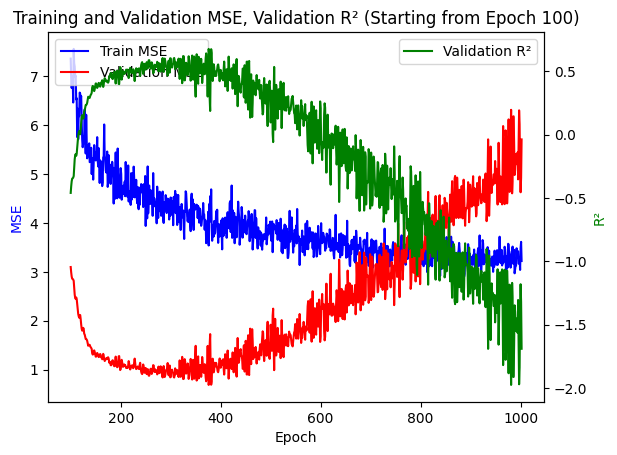

[I 2024-09-01 23:29:11,563] Trial 19 finished with value: 5.709916591644287 and parameters: {'num_conv_blocks': 1, 'num_fc_blocks': 3, 'kernel_size_conv1': 5, 'num_kernels_conv1': 8, 'num_neurons_fc1': 140, 'num_neurons_fc2': 185, 'num_neurons_fc3': 160, 'batch_size': 256, 'num_epochs': 1762, 'lr': 0.00012566973978378406}. Best is trial 16 with value: 0.16895648837089539.


最优超参数: {'num_conv_blocks': 1, 'num_fc_blocks': 3, 'kernel_size_conv1': 5, 'num_kernels_conv1': 8, 'num_neurons_fc1': 125, 'num_neurons_fc2': 133, 'num_neurons_fc3': 195, 'batch_size': 8, 'num_epochs': 1848, 'lr': 0.001247079321913181}
最优目标值 (mse): 0.16895648837089539


In [8]:
# 创建一个Optuna study对象
study = optuna.create_study(direction='minimize')

# 存储最佳 R-squared 值
study.best_mse = None

study.optimize(objective, n_trials=20)


# 输出最优超参数和目标值
print("最优超参数:", study.best_params)
print("最优目标值 (mse):", study.best_value)

In [ ]:
def prepare_test_data(file_path):
    
    df = pd.read_excel(file_path, header=0, engine='openpyxl')

    # Extract features and labels
    #features = df.iloc[:, selected_columns].values
    features = df.iloc[:, 1:].values
    labels = df.iloc[:, 0].values

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)    
    
    # Convert to PyTorch tensors
    X_test_tensor = torch.FloatTensor(features_scaled).unsqueeze(1).cuda()  # Add channel dimension
    y_test_tensor = torch.FloatTensor(labels).view(-1, 1).cuda()
    
    #X_test_tensor = normalize(X_test_tensor, dim=0)

    return X_test_tensor, y_test_tensor

# Load the independent test data
X_independent_test, y_independent_test = prepare_test_data('C:\\Users\\HongYI\\Desktop\\test.xlsx')

best_params = study.best_params

#构建卷积块和全连接块的参数
conv_params = []
for i in range(best_params['num_conv_blocks']):
    kernel_size = best_params[f'kernel_size_conv{i+1}']
    num_kernels = best_params[f'num_kernels_conv{i+1}']
    conv_params.append({'kernel_size': kernel_size, 'num_kernels': num_kernels})

fc_params = []
for i in range(best_params['num_fc_blocks']):
    dropout = 0.5
    num_neurons = best_params[f'num_neurons_fc{i+1}']
    fc_params.append({'num_neurons': num_neurons, 'dropout': dropout})

batch_size = best_params['batch_size']
num_epochs = best_params['num_epochs']



tuned_model = CNN1D(input_size=X_independent_test.size(2), output_size=1,
                    conv_params=conv_params, 
                    fc_params=fc_params, 
                    batch_size=batch_size).cuda()

# Load the trained weights
tuned_model.load_state_dict(torch.load('model_weights_test.pth'), strict=False)
# Set the model to evaluation mode
tuned_model.eval()
#tuned_model.train()
# Make predictions on the test set
with torch.no_grad():
    predictions = tuned_model(X_independent_test)

# Convert predictions and true labels to NumPy arrays
predictions_cpu = predictions.cpu().numpy()
y_in_test_cpu = y_independent_test.cpu().numpy()

# Evaluate the performance (e.g., R-squared)
r2 = r2_score(y_in_test_cpu, predictions_cpu.squeeze())
mse = mean_squared_error(y_in_test_cpu, predictions_cpu.squeeze())

print(f"R-squared on the test set: {r2}")
print(f"mse on the test set: {mse}")

In [ ]:
# 设置模型为训练模式（启用 Monte Carlo Dropout）
tuned_model.train()

# 设置 Monte Carlo 采样数量
num_samples = 100  # 你可以根据需要调整这个数值

# 列表用于存储每个样本的预测结果和真实值
all_true_values = y_independent_test.cpu().numpy().squeeze()  # 获取真实值
all_predictions = [[] for _ in range(len(y_independent_test))]  # 初始化用于存储预测值的列表
std_values = []

# 使用 Monte Carlo Dropout 进行多次预测
with torch.no_grad():
    for sample_index in range(num_samples):
        predictions = tuned_model(X_independent_test)
        predictions_np = predictions.cpu().numpy().squeeze()
        
        # 将每次预测结果添加到对应的样本中
        for i in range(len(predictions_np)):
            all_predictions[i].append(predictions_np[i])

# 计算每个样本预测结果的标准差
for preds in all_predictions:
    std_i = np.std(preds)
    std_values.append(std_i)

# 创建 DataFrame，保存每个样本的真实值、预测结果和标准差
df_results = pd.DataFrame({
    'True_Value': all_true_values,
    **{f'Prediction_{i+1}': [pred[i] for pred in all_predictions] for i in range(num_samples)},
    'Std_Dev': std_values
})

# 保存 DataFrame 到 CSV 文件
df_results.to_csv('C:\\Users\\HongYI\\Desktop\\meeting\\test.csv', index=False)

# 打印或可视化结果
print(df_results)

# 计算总体的标准差范围
std_range = np.percentile(std_values, [2.5, 97.5])

print(f"Overall Std Dev range: {std_range}")


In [ ]:
def prepare_test_data(file_path):
    
    
    df = pd.read_excel(file_path, header=0, engine='openpyxl')

    # Extract features and labels
    #features = df.iloc[:, selected_columns].values
    features = df.iloc[:, 1:].values
    labels = df.iloc[:, 0].values

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)    
    
    # Convert to PyTorch tensors
    X_test_tensor = torch.FloatTensor(features_scaled).unsqueeze(1).cuda()  # Add channel dimension
    y_test_tensor = torch.FloatTensor(labels).view(-1, 1).cuda()
    
    #X_test_tensor = normalize(X_test_tensor, dim=0)

    return X_test_tensor, y_test_tensor

# Load the independent test data
X_independent_test, y_independent_test = prepare_test_data('C:\\Users\\HongYI\\Desktop\\test.xlsx')

best_params = study.best_params

#构建卷积块和全连接块的参数
conv_params = []
for i in range(best_params['num_conv_blocks']):
    kernel_size = best_params[f'kernel_size_conv{i+1}']
    num_kernels = best_params[f'num_kernels_conv{i+1}']
    conv_params.append({'kernel_size': kernel_size, 'num_kernels': num_kernels})

fc_params = []
for i in range(best_params['num_fc_blocks']):
    dropout = 0.7
    num_neurons = best_params[f'num_neurons_fc{i+1}']
    fc_params.append({'num_neurons': num_neurons, 'dropout': dropout})

batch_size = best_params['batch_size']
num_epochs = best_params['num_epochs']



tuned_model = CNN1D(input_size=X_independent_test.size(2), output_size=1,
                    conv_params=conv_params, 
                    fc_params=fc_params, 
                    batch_size=batch_size).cuda()

# Load the trained weights
tuned_model.load_state_dict(torch.load('model_weights_test.pth'), strict=False)
# Set the model to evaluation mode
tuned_model.eval()
#tuned_model.train()
# Make predictions on the test set
with torch.no_grad():
    predictions = tuned_model(X_independent_test)

# Convert predictions and true labels to NumPy arrays
predictions_cpu = predictions.cpu().numpy()
y_in_test_cpu = y_independent_test.cpu().numpy()

# Evaluate the performance (e.g., R-squared)
r2 = r2_score(y_in_test_cpu, predictions_cpu.squeeze())
mse = mean_squared_error(y_in_test_cpu, predictions_cpu.squeeze())

print(f"R-squared on the test set: {r2}")
print(f"mse on the test set: {mse}")

In [ ]:
# 设置模型为训练模式（启用 Monte Carlo Dropout）
tuned_model.train()

# 设置 Monte Carlo 采样数量
num_samples = 100  # 你可以根据需要调整这个数值

# 列表用于存储每个样本的预测结果和真实值
all_true_values = y_independent_test.cpu().numpy().squeeze()  # 获取真实值
all_predictions = [[] for _ in range(len(y_independent_test))]  # 初始化用于存储预测值的列表
std_values = []

# 使用 Monte Carlo Dropout 进行多次预测
with torch.no_grad():
    for sample_index in range(num_samples):
        predictions = tuned_model(X_independent_test)
        predictions_np = predictions.cpu().numpy().squeeze()
        
        # 将每次预测结果添加到对应的样本中
        for i in range(len(predictions_np)):
            all_predictions[i].append(predictions_np[i])

# 计算每个样本预测结果的标准差
for preds in all_predictions:
    std_i = np.std(preds)
    std_values.append(std_i)

# 创建 DataFrame，保存每个样本的真实值、预测结果和标准差
df_results = pd.DataFrame({
    'True_Value': all_true_values,
    **{f'Prediction_{i+1}': [pred[i] for pred in all_predictions] for i in range(num_samples)},
    'Std_Dev': std_values
})

# 保存 DataFrame 到 CSV 文件
df_results.to_csv('C:\\Users\\HongYI\\Desktop\\meeting\\1dcnn.csv', index=False)

# 打印或可视化结果
print(df_results)

# 计算总体的标准差范围
std_range = np.percentile(std_values, [2.5, 97.5])

print(f"Overall Std Dev range: {std_range}")

In [ ]:
##################ResNet
############################
import torch
import torch.nn as nn

class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ResidualBlock1D, self).__init__()
        padding_size = (kernel_size - 1) // 2

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding_size)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding_size)

        if in_channels != out_channels:
            self.residual = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        else:
            self.residual = nn.Identity()

    def forward(self, x):
        residual = self.residual(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x += residual
        return self.relu(x)

class CNN1D(nn.Module):
    def __init__(self, input_size, output_size, conv_params, fc_params, batch_size):
        super(CNN1D, self).__init__()

        self.conv_layers = nn.ModuleList()
        input_channels = 1
        for params in conv_params:
            kernel_size = params['kernel_size']
            num_kernels = params['num_kernels']
            self.conv_layers.append(ResidualBlock1D(input_channels, num_kernels, kernel_size))
            input_channels = num_kernels

        with torch.no_grad():
            sample_output = self._forward_conv(torch.randn(batch_size, 1, input_size))
            calculated_input_size = sample_output.view(sample_output.size(0), -1).size(1)

        self.fc_layers = nn.ModuleList()
        fc_input_size = calculated_input_size
        for params in fc_params:
            num_neurons = params['num_neurons']
            dropout = params['dropout']
            self.fc_layers.append(nn.Sequential(
                nn.Linear(fc_input_size, num_neurons),
                nn.ReLU(),
                nn.Dropout(p=dropout)
            ))
            fc_input_size = num_neurons

        self.fc_final = nn.Linear(fc_input_size, output_size)

    def _forward_conv(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        for layer in self.fc_layers:
            x = layer(x)
        x = self.fc_final(x)
        return x


In [5]:
from sklearn.metrics import mean_squared_error

def objective(trial):
    seed = 42
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    # 控制卷积块和全连接块的数量
    num_conv_blocks = trial.suggest_int('num_conv_blocks', 1, 3)
    num_fc_blocks = trial.suggest_int('num_fc_blocks', 1, 3)
    
    # 构建卷积块和全连接块的参数
    powers_of_two = [2**i for i in range(1, 5)]  # 2, 4, 8, 16
    conv_params = []
    for i in range(num_conv_blocks):
        kernel_size = trial.suggest_categorical(f'kernel_size_conv{i+1}', [3, 5, 9, 11, 13])
        num_kernels = trial.suggest_categorical(f'num_kernels_conv{i+1}', powers_of_two)
        conv_params.append({'kernel_size': kernel_size, 'num_kernels': num_kernels})
    
    fc_params = []
    for i in range(num_fc_blocks):
        dropout = 0.2
        num_neurons = trial.suggest_int(f'num_neurons_fc{i+1}', 10, 200)
        fc_params.append({'num_neurons': num_neurons, 'dropout': dropout})
    
    batch_size_powers = [2**i for i in range(3, 12)]  # 64, 128, 256
    batch_size = trial.suggest_categorical('batch_size', batch_size_powers)
    num_epochs = trial.suggest_int('num_epochs', 500, 2000)
    lr = trial.suggest_float('lr', 0.0001, 0.01)
    
    # 数据准备
    X_train, y_train, X_val, y_val = prepare_data('C:\\Users\\HongYI\\Desktop\\train_s.xlsx')

    # 创建模型
    input_size = X_train.size(2)
    output_size = 1

    model = CNN1D(input_size=input_size, output_size=output_size,
                  conv_params=conv_params, fc_params=fc_params, batch_size=batch_size)
    model = model.cuda()
    
    save_path = 'model_weights.pth'
    save_path_test = 'model_weights_test.pth'
    
    # 训练模型
    X_val, y_val = X_val.cuda(), y_val.cuda()
    
    train_model(model, 
                X_train, y_train, 
                X_val, y_val, 
                num_epochs=num_epochs, 
                lr=lr, 
                batch_size=batch_size, 
                patience=1000,
                save_path=save_path)

    model.eval()
    with torch.no_grad():
        predictions = model(X_val)

    predictions_cpu = predictions.cpu().numpy()
    y_val_cpu = y_val.cpu().numpy()   
     
    # 计算 MSE
    mse = mean_squared_error(y_val_cpu, predictions_cpu.squeeze())

    # 在每次评估后保存最佳模型权重
    if trial.should_prune():
        return mse
    
    if study.best_mse is None or mse < study.best_mse:
        study.best_mse = mse
        # 保存最佳权重
        torch.save(model.state_dict(), save_path_test)

    # 返回需要最小化的目标值
    return mse


In [6]:
import matplotlib.pyplot as plt

def train_model(model, X_train, y_train, X_val, y_val, num_epochs, batch_size, lr, patience, save_path):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # 添加余弦退火学习率调度器
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

    # 数据加载器
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    train_losses = []
    val_losses = []
    val_r2_scores = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # 记录当前学习率
        current_lr = optimizer.param_groups[0]['lr']
        
        # 在每个 epoch 结束后计算并打印验证集上的损失
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            val_predictions = []  # 清空验证集预测结果列表
            for batch_X_val, batch_y_val in val_loader:
                batch_X_val, batch_y_val = batch_X_val.cuda(), batch_y_val.cuda()
                val_outputs = model(batch_X_val)
                val_loss += criterion(val_outputs, batch_y_val)
                val_predictions.append(val_outputs.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss.item())
        val_predictions = np.concatenate(val_predictions)
        val_r2 = r2_score(y_val.cpu().numpy(), val_predictions)
        val_r2_scores.append(val_r2)
        
        # 每100个epoch打印一次
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, R^2 (Validation): {val_r2:.4f}")

        # 使用余弦退火学习率调度器更新学习率
        scheduler.step()        

        # 提前停止的逻辑
        if epoch > patience and avg_val_loss > min(val_losses[-patience:]):
            print("Early stopping")
            break

    # 保存训练好的模型权重
    torch.save(model.state_dict(), save_path)

    # 训练结束后绘制图像
    # Ignoring the first 10 epochs for plotting
    start_epoch = 100
    epochs = range(start_epoch, len(train_losses) + 1)
    
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(epochs, train_losses[start_epoch-1:], 'b-', label='Train MSE')
    ax1.plot(epochs, val_losses[start_epoch-1:], 'r-', label='Validation MSE')
    ax2.plot(epochs, val_r2_scores[start_epoch-1:], 'g-', label='Validation R²')

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE', color='b')
    ax2.set_ylabel('R²', color='g')
    
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    plt.title(f"Training and Validation MSE, Validation R² (Starting from Epoch {start_epoch})")
    plt.show()

    return avg_val_loss.item()


In [9]:
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

def prepare_test_data(file_path):
    df = pd.read_excel(file_path, header=0, engine='openpyxl')

    # Extract features and labels
    features = df.iloc[:, 1:].values
    labels = df.iloc[:, 0].values

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)    
    
    # Convert to PyTorch tensors
    X_test_tensor = torch.FloatTensor(features_scaled).unsqueeze(1).cuda()  # Add channel dimension
    y_test_tensor = torch.FloatTensor(labels).view(-1, 1).cuda()

    return X_test_tensor, y_test_tensor

# Load the independent test data
X_independent_test, y_independent_test = prepare_test_data('C:\\Users\\HongYI\\Desktop\\test_s.xlsx')

best_params = study.best_params

# Construct convolutional and fully connected layer parameters
conv_params = []
for i in range(best_params['num_conv_blocks']):
    kernel_size = best_params[f'kernel_size_conv{i+1}']
    num_kernels = best_params[f'num_kernels_conv{i+1}']
    conv_params.append({'kernel_size': kernel_size, 'num_kernels': num_kernels})

fc_params = []
for i in range(best_params['num_fc_blocks']):
    dropout = 0.7
    num_neurons = best_params[f'num_neurons_fc{i+1}']
    fc_params.append({'num_neurons': num_neurons, 'dropout': dropout})

batch_size = best_params['batch_size']
num_epochs = best_params['num_epochs']

tuned_model = CNN1D(input_size=X_independent_test.size(2), output_size=1,
                    conv_params=conv_params, 
                    fc_params=fc_params, 
                    batch_size=batch_size).cuda()

# Load the trained weights
tuned_model.load_state_dict(torch.load('model_weights_test.pth'), strict=False)
# Set the model to evaluation mode
tuned_model.eval()

# Make predictions on the test set
with torch.no_grad():
    predictions = tuned_model(X_independent_test)

# Convert predictions and true labels to NumPy arrays and squeeze them to 1D
predictions_cpu = predictions.cpu().numpy().squeeze()
y_in_test_cpu = y_independent_test.cpu().numpy().squeeze()

# Evaluate the performance (e.g., R-squared and MSE)
r2 = r2_score(y_in_test_cpu, predictions_cpu)
mse = mean_squared_error(y_in_test_cpu, predictions_cpu)

print(f"R-squared on the test set: {r2}")
print(f"MSE on the test set: {mse}")

# Save the predictions and true values to a CSV file
df_results = pd.DataFrame({
    'True_Value': y_in_test_cpu,
    'Prediction': predictions_cpu
})

df_results.to_csv('C:\\Users\\HongYI\\Desktop\\predictions_vs_true_values.csv', index=False)

print("Predictions and true values have been saved to 'predictions_vs_true_values_s.csv'.")


R-squared on the test set: 0.9186484358469997
MSE on the test set: 0.1884937435388565
Predictions and true values have been saved to 'predictions_vs_true_values_s.csv'.
